# Proximity Project

Gabi Capone

5 November 2023

This notebook performs proximity analysis on library locations in New York City by cenusus tracts. Areas data is sourced from the 2015 - 2019 American Community Survey via Michael Minn (https://michaelminn.net/tutorials/data/2015-2019-acs-counties.geojson). 

<Figure size 1728x1728 with 0 Axes>

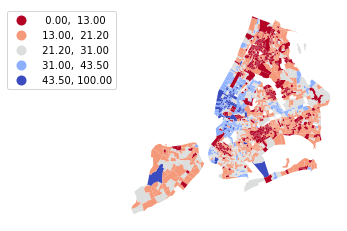

In [1]:
import pandas
import geopandas
import matplotlib.pyplot as plt

tracts = geopandas.read_file("https://michaelminn.net/tutorials/data/2015-2019-acs-tracts.geojson")
libraries = geopandas.read_file("https://data.cityofnewyork.us/api/geospatial/p4pf-fyc4?method=export&format=GeoJSON")

nyc_county_fips = ["US36061", "US36047", "US36005", "US36085", "US36081"]

nyc_tracts = tracts[tracts["FactFinder GEOID"].str.contains('|'.join(nyc_county_fips))]

nyc_tracts = nyc_tracts.to_crs('EPSG:6538')

plt.figure(figsize=(24, 24))

axis = nyc_tracts.plot("Percent Bachelors Degree", scheme = "naturalbreaks", 
                       cmap= "coolwarm_r", edgecolor = "none", legend = True,
                       legend_kwds={"bbox_to_anchor":(0, 1)})

axis.set_axis_off()

plt.show()

Point data of NYC library locations comes from the City of New York's Open Data Portal (https://data.cityofnewyork.us/Business/Library/p4pf-fyc4).

<Figure size 1728x1728 with 0 Axes>

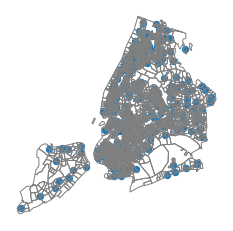

In [2]:
libraries = libraries.to_crs('EPSG:6538')

nyc_tracts = nyc_tracts.to_crs(libraries.crs)

libraries = libraries.sjoin(nyc_tracts)

plt.figure(figsize=(24, 24))

axis = libraries.plot(markersize=40)

nyc_tracts.plot(facecolor="none", edgecolor="gray", ax=axis)

axis.set_axis_off()

plt.show()

As this notebook deals with quantifying accessibility, proximity analysis using buffers served as the main technique of analysis.

Although the majority of census tracts are not home to a library, it appears that there is a relatively even distribution of libraries across New York City. 

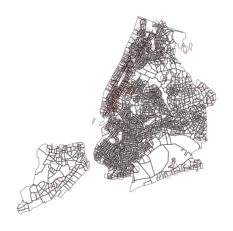

<Figure size 1728x1728 with 0 Axes>

In [3]:
lib_buffers = libraries.copy()

lib_buffers["geometry"] = libraries.buffer(800)

axis = lib_buffers.plot(edgecolor ="#80000040", facecolor= "none")
nyc_tracts.plot(edgecolor = "#00000040", facecolor="none", ax=axis)

plt.figure(figsize=(24, 24))

axis.set_axis_off()

plt.show()

In [4]:
lib_buffers = lib_buffers.rename(columns={'index_right': 'Streets'})
lib_tracts = lib_buffers.sjoin(nyc_tracts)

lib_tracts["Library Count"] = 1

lib_tracts = lib_tracts.groupby("FactFinder GEOID_left")["Library Count"].count()

lib_tracts = lib_tracts.reset_index()

lib_tracts = nyc_tracts.merge(lib_tracts, left_on="FactFinder GEOID", right_on="FactFinder GEOID_left", how="left")


lib_tracts["Library Count"] = lib_tracts["Library Count"].fillna(0)

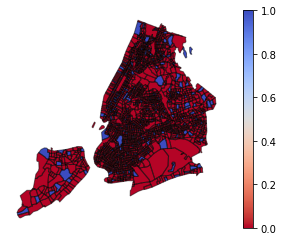

In [5]:

lib_tracts['Library Accessible'] = (lib_tracts["Library Count"] > 0)

axis = lib_tracts.plot("Library Accessible",
                       cmap="coolwarm_r", legend=True, edgecolor="none")

nyc_tracts.plot(edgecolor="#00000080", facecolor="none", ax=axis)

axis.set_axis_off()

plt.show()


In [6]:
lib_tracts = geopandas.sjoin(lib_tracts, nyc_tracts, op='intersects', how='left')

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.9.0/lib/python3.8/site-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'FactFinder GEOID_left'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In New York City, 89% of residents live in library accessible areas. 

The median and mean where libraries are accessible are 20.3 and 22.39 for the Percent Bachelors Degree, which is marginally higher
compared to the median and mean of library inaccessible areas (median:19.3, mean: 21.15). On average, areas with library accessibility have a slightly higher percentage of people with bachelor's degrees. 

This analysis could help decision making by detailing census tracts that have higher access to educational resources, highlight social equity issues for community resource allocation, and help guide where to invest in infrastructure to promote greater access to educational resources. 


Library Accessible
False    89.092253
True     10.907747
Name: Total Population_right, dtype: float64
                      count       mean        std  min   25%   50%     75%  \
Library Accessible                                                           
False               13916.0  21.152041  10.766136  0.0  13.8  19.3  26.800   
True                 1538.0  22.396684  11.761321  0.0  13.9  20.3  29.075   

                      max  
Library Accessible         
False               100.0  
True                100.0  


<Figure size 1800x720 with 0 Axes>

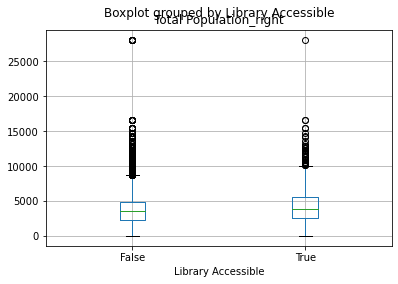

In [7]:
access_population = lib_tracts.groupby('Library Accessible')['Total Population_right'].sum()

print(100 * access_population /lib_tracts['Total Population_right'].sum())

print(lib_tracts.groupby("Library Accessible")["Percent Bachelors Degree_right"].describe())

plt.figure(figsize=(25, 10))

lib_tracts.boxplot("Total Population_right", "Library Accessible")

plt.show()